# GRAPE First Order, Implementing Single Qubit Rotation
Ref: https://github.com/qutip/qutip-notebooks/blob/master/examples/control-grape-single-qubit-rotation.ipynb

## Import libraries

In [160]:
import matplotlib.pyplot as plt
import time
import numpy as np
from qutip import *
from qutip.control import *
from qutip_qip.operations import rz, rx
from qutip import QobjEvo, Options
%matplotlib inline

## Define Constants and Hamiltonian

In [161]:
T = 2 * np.pi # Period
times = np.linspace(0, T, 500)
theta, phi = np.random.rand(2)

#Target unitary
U = rz(theta) * rx(phi)
U

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.83175851-0.44450498j -0.15674381-0.29329929j]
 [ 0.15674381-0.29329929j  0.83175851+0.44450498j]]

In [162]:
times.dtype

dtype('float64')

In [163]:
R = 500 # Number of learning iterations
H_ops = [sigmax(), sigmay(), sigmaz()] # Control Hamiltonians
H_labels = [r'$u_{x}$', r'$u_{y}$', r'$u_{z}$']
H0 = 0 * np.pi * sigmaz() # Drift Hamiltonian

In [164]:
u0 = np.array([np.random.rand(len(times)) * 2 * np.pi * 0.005 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

## GRAPE

In [165]:
from qutip.control.grape import plot_grape_control_fields, grape_unitary, grape_unitary_adaptive
from qutip.control.grape import _overlap
from qutip.ui.progressbar import TextProgressBar as ProgressBar

In [166]:
u_limits = None
alpha = None
eps = 2 * np.pi * 0.01

In [167]:
result = grape_unitary(U, H0, H_ops, R, times, u_start=u0, u_limits=u_limits,
                       eps=eps,
                       alpha=alpha,
                       progress_bar=ProgressBar(R),
                       phase_sensitive=False
                       )


10.0%. Run time:  14.02s. Est. time left: 00:00:02:06
20.0%. Run time:  29.32s. Est. time left: 00:00:01:57
30.0%. Run time:  44.43s. Est. time left: 00:00:01:43
40.0%. Run time:  59.95s. Est. time left: 00:00:01:29
50.0%. Run time:  76.51s. Est. time left: 00:00:01:16
60.0%. Run time:  89.23s. Est. time left: 00:00:00:59
70.0%. Run time: 104.48s. Est. time left: 00:00:00:44
80.0%. Run time: 118.58s. Est. time left: 00:00:00:29
90.0%. Run time: 138.59s. Est. time left: 00:00:00:15
Total run time: 153.54s


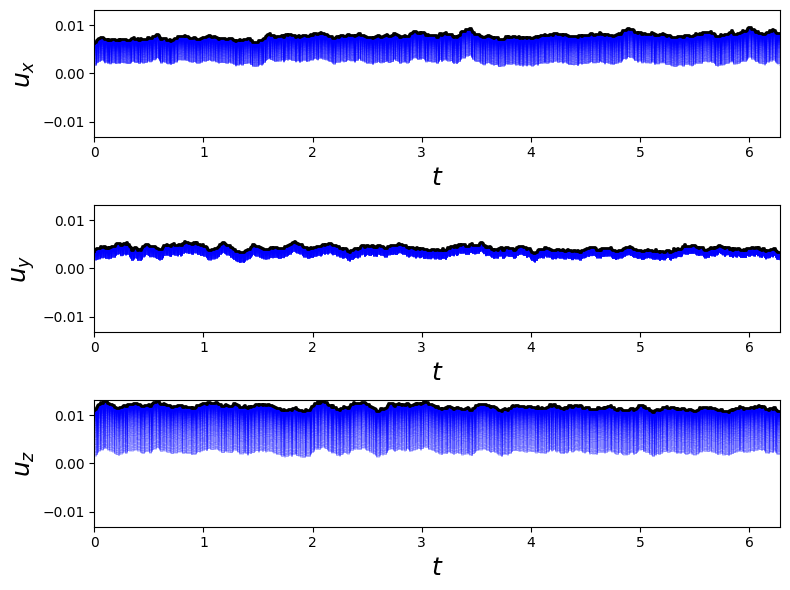

In [168]:
plot_grape_control_fields(times, result.u / (2 * np.pi), H_labels, uniform_axes=True);

## Fidelity and Overlap b/w ideal and optimized

In [169]:
U

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.83175851-0.44450498j -0.15674381-0.29329929j]
 [ 0.15674381-0.29329929j  0.83175851+0.44450498j]]

In [170]:
result.U_f

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.83353997-0.44214631j -0.15640581-0.29198457j]
 [ 0.15640581-0.29198457j  0.83353997+0.44214631j]]

In [171]:
result.U_f/result.U_f[0,0]

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 1.        -5.55111512e-17j -0.00142718-3.51051661e-01j]
 [ 0.29144734-1.95698114e-01j  0.56082836+8.27932096e-01j]]

In [172]:
_overlap(U, result.U_f).real, abs(_overlap(U, result.U_f))**2

(0.9999947101607088, 0.9999894203494001)

## Verify the Correctmess of the Hamiltonian Pulses by Integration

In [173]:
# Convert Qobj to QobjEvo
H_t_evo = QobjEvo(result.H_t, tlist=times)

In [ ]:
c_ops = []
U_f_num = propagator(H_t_evo, times[-1], c_ops, options=Options(nstep=5000),args={}) 

In [175]:
_overlap(result.U_f, U_f_num).real, abs(_overlap(result.U_f, U_f_num))**2

(0.9999999951699785, 0.999999990339957)

## Bloch Sphere

In [176]:
psi0 = basis(2, 0)
e_ops = [sigmax(), sigmay(), sigmaz()]

In [177]:
me_result = mesolve(result.H_t, psi0, times, c_ops, e_ops)

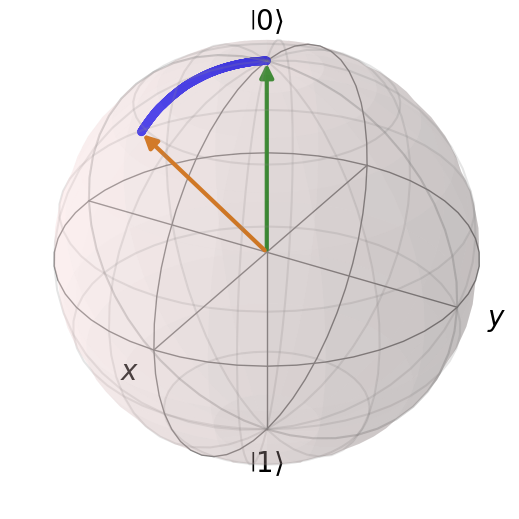

In [178]:
b = Bloch()

b.add_points(me_result.expect)

b.add_states(psi0)
b.add_states(U * psi0)
b.render()

## Tomography

In [179]:
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]]
op_label = [["i", "x", "y", "z"]]

In [180]:
fig = plt.figure(figsize=(8,6))

U_ideal = spre(U) * spost(U.dag())

chi = qpt(U_ideal, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

Error in callback <function _draw_all_if_interactive at 0x000001CF81D36020> (for post_execute), with arguments args (),kwargs {}:


TypeError: _remove_margins.<locals>._get_coord_info_new() missing 1 required positional argument: 'renderer'

TypeError: _remove_margins.<locals>._get_coord_info_new() missing 1 required positional argument: 'renderer'

<Figure size 800x600 with 2 Axes>